### Evaluation code for the dataset Bla bla

Short description of metrics and panels

#### General imports

In [ ]:
import pooch
import numpy as np
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt

from microsplit_reproducibility.configs.factory import (
    get_algorithm_config,
    get_likelihood_config,
    get_loss_config,
    get_model_config,
    get_optimizer_config,
    get_training_config,
    get_lr_scheduler_config,
)
from microsplit_reproducibility.utils.io import load_checkpoint
from microsplit_reproducibility.datasets import create_train_val_datasets

from careamics.lightning import VAEModule
from careamics.lvae_training.eval_utils import (
    get_predictions, get_samples, plot_error
)
from careamics.utils.metrics import avg_range_inv_psnr

#### Experiments specific imports

In [ ]:
from microsplit_reproducibility.configs.parameters.pavia_p24 import get_denoisplit_parameters
from microsplit_reproducibility.configs.data.pavia_p24 import get_data_configs
from microsplit_reproducibility.datasets.pavia_p24 import get_train_val_data

### Get configs

In [ ]:
train_data_config, val_data_config, test_data_configs = get_data_configs()
experiment_params = get_denoisplit_parameters()

### Create dataset

In [ ]:
tmp_local_path = "/localscratch/data/pavia3_sequential_cropped"

In [ ]:
DATA = pooch.create(
    # path=pooch.os_cache("microsplit_reproducibility_pavia_p24"), # TODO should be downloaded and stored locally
    path=tmp_local_path,
    base_url="",
    registry={"":""},
)

In [ ]:
train_dset, val_dset, test_dset, data_stats = create_train_val_datasets(
    datapath=tmp_local_path,
    train_config=train_data_config,
    val_config=val_data_config,
    test_config=val_data_config,
    load_data_func=get_train_val_data,
)

# TODO problem is, creating a dataloader requires a config, that's ugly af

### Get experiment configs

In [ ]:
experiment_params["data_stats"] = data_stats # TODO rethink

loss_config = get_loss_config(**experiment_params)
model_config = get_model_config(**experiment_params)
gaussian_lik_config, noise_model_config, nm_lik_config = get_likelihood_config(
    **experiment_params
)
training_config = get_training_config(**experiment_params)
lr_scheduler_config = get_lr_scheduler_config(**experiment_params)
optimizer_config = get_optimizer_config(**experiment_params)

# TODO rename to create
experiment_config = get_algorithm_config(
    algorithm=experiment_params["algorithm"],
    loss_config=loss_config,
    model_config=model_config,
    gaussian_lik_config=gaussian_lik_config,
    nm_config=noise_model_config,
    nm_lik_config=nm_lik_config,
    lr_scheduler_config=lr_scheduler_config,
    optimizer_config=optimizer_config,
)

### Create model and load checkpoint

In [ ]:
lightning_model = VAEModule(algorithm_config=experiment_config)


In [ ]:
ckpt = load_checkpoint("checkpoints", best=False)
lightning_model.load_state_dict(ckpt['state_dict'], strict=True)
lightning_model.eval()
lightning_model.cuda()

### Get samples from the 

Explain

In [ ]:
dataset_sample, predicted_sample = get_samples(model=lightning_model, dset=test_dset, sample_idx=10)

In [ ]:
dataset_sample.shape, predicted_sample.shape

### Visualize samples

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(dataset_sample[1], cmap='gray')
ax[0].set_title("Original")
ax[1].imshow(predicted_sample[1], cmap='gray')
ax[1].set_title("Reconstructed")

### Perform evaluation

In [ ]:
tiled_predictions, stitched_predictions = get_predictions(
  model=lightning_model,
  dset=test_dset,
  batch_size=experiment_params["batch_size"],
  num_workers=experiment_params["num_workers"],
  mmse_count=1,
)

In [ ]:
file_idx = 0 # TODO dataset specific index 
target = test_dset.dsets[file_idx]._data
predictions = stitched_predictions[file_idx]

sep_mean = np.transpose(data_stats[0].numpy(), axes=(0, 2, 3, 1))
sep_std = np.transpose(data_stats[1].numpy(), axes=(0, 2, 3, 1))

target_normalized = (target - sep_mean)/ sep_std

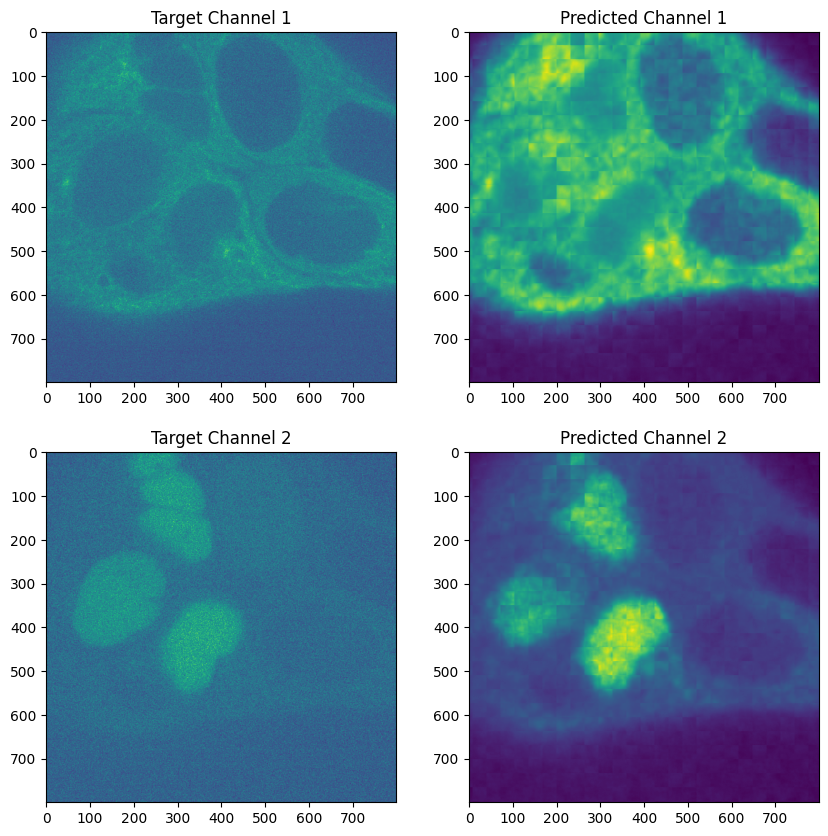

In [35]:
# One random target vs predicted image (patch of shape [sz x sz])
ncols = target.shape[-1]
_,ax = plt.subplots(figsize=(ncols*5, 2*5), nrows=2, ncols=ncols)
img_idx = 10
sz = 800
hs = np.random.randint(target.shape[1] - sz)
ws = np.random.randint(target.shape[2] - sz)
for i in range(ncols):
    ax[i,0].set_title(f'Target Channel {i+1}')
    ax[i,0].imshow(target[0, hs:hs+sz, ws:ws+sz, i])
    ax[i,1].set_title(f'Predicted Channel {i+1}')
    ax[i,1].imshow(predictions[0, hs:hs+sz, ws:ws+sz, i])

# plt.subplots_adjust(wspace=0.1, hspace=0.1)
# clean_ax(ax)

0


/home/igor.zubarev/projects/careamics/src/careamics/lvae_training/eval_utils.py:425: UserWarning: Overwriting the cmap 'shiftedcmap' that was already in the registry.
  matplotlib.colormaps.register(cmap=newcmap, force=True)


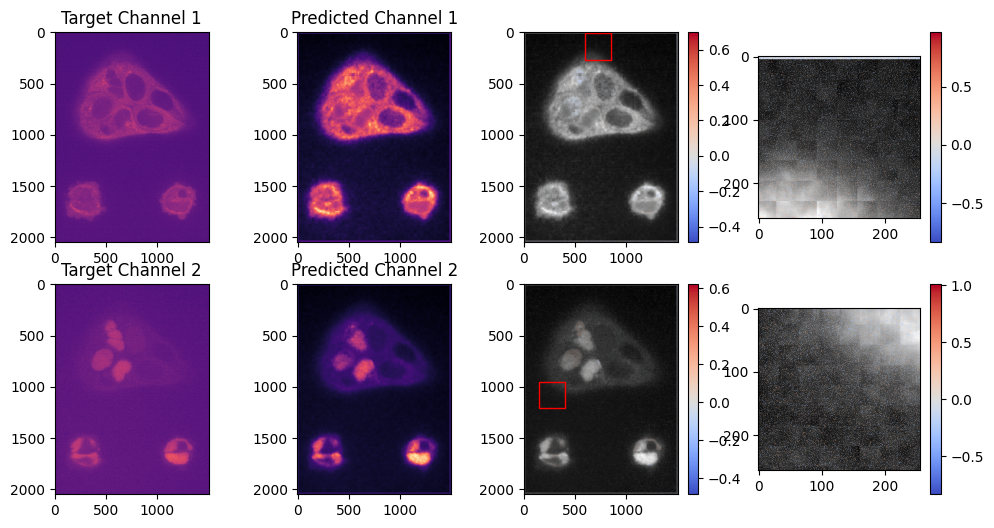

In [36]:
nrows = stitched_predictions[file_idx].shape[-1]
img_sz = 3
_,ax = plt.subplots(figsize=(4*img_sz,nrows*img_sz), ncols=4, nrows=nrows)
idx = np.random.randint(len(stitched_predictions[file_idx]))
print(idx)
for ch_id in range(nrows):
    ax[ch_id,0].set_title(f'Target Channel {ch_id+1}')
    ax[ch_id,0].imshow(target_normalized[idx,..., ch_id], cmap='magma')
    ax[ch_id,1].set_title(f'Predicted Channel {ch_id+1}')
    ax[ch_id,1].imshow(predictions[idx,:,:,ch_id], cmap='magma')
    plot_error(
        target_normalized[idx,...,ch_id],
        predictions[idx,:,:,ch_id],
        cmap = mpl.cm.coolwarm,
        ax = ax[ch_id,2],
        max_val = None
    )

    cropsz = 256
    h_s = np.random.randint(0, target_normalized.shape[1] - cropsz)
    h_e = h_s + cropsz
    w_s = np.random.randint(0, target_normalized.shape[2] - cropsz)
    w_e = w_s + cropsz

    plot_error(
        target_normalized[idx,h_s:h_e,w_s:w_e, ch_id],
        predictions[idx,h_s:h_e,w_s:w_e,ch_id],
        cmap = mpl.cm.coolwarm,
        ax = ax[ch_id,3],
        max_val = None
    )

    # Add rectangle to the region
    rect = patches.Rectangle((w_s, h_s), w_e-w_s, h_e-h_s, linewidth=1, edgecolor='r', facecolor='none')
    ax[ch_id,2].add_patch(rect)


In [ ]:
rmse_arr = []
psnr_arr = []
rinv_psnr_arr = []
ssim_arr = []
for ch_id in range(predictions.shape[-1]):
    rmse =np.sqrt(((predictions[...,ch_id] - target_normalized[...,ch_id])**2).reshape(len(predictions),-1).mean(axis=1))
    rmse_arr.append(rmse)
    # psnr = avg_psnr(tar_normalized[...,ch_id].copy(), pred[...,ch_id].copy())
    rinv_psnr = avg_range_inv_psnr(target_normalized[...,ch_id].copy(), predictions[...,ch_id].copy())
    # ssim_mean, ssim_std = avg_ssim(tar[...,ch_id], pred_unnorm[ch_id])
    # psnr_arr.append(psnr)
    rinv_psnr_arr.append(rinv_psnr)
    # ssim_arr.append((ssim_mean,ssim_std))

In [ ]:
# print('Rec Loss: ', np.round(rec_loss.mean(),3) )
print('RMSE: ', ' <--> '.join([str(np.mean(x).round(3)) for x in rmse_arr]))
print('PSNR: ', ' <--> '.join([str(x) for x in psnr_arr]))
print('RangeInvPSNR: ',' <--> '.join([str(x) for x in rinv_psnr_arr]))
print('SSIM: ',' <--> '.join([f'{round(x,3)}±{round(y,4)}' for (x,y) in ssim_arr]))
print()

In [ ]:
# TODO discuss visualing inidividual samples vs mmse. do both! 

### Visualize results


### Panel 1 ...